In [92]:
import sys
sys.path.append('/home/afroroboticist/.virtualenvs/movieRecommender-QRQOtrCB/lib/python3.8/site-packages')
sys.path.append('/home/afroroboticist/.virtualenvs/movieRec-GPy9DBCD/lib/python3.8/site-packages')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from category_encoders import OrdinalEncoder, OneHotEncoder
import pickle

In [61]:
pd.options.display.max_rows = 30
pd.options.display.max_columns = 30

In [62]:
df = pd.read_csv('static/movie_data_training_set.csv')
movie_data = pd.read_csv('static/movies_metadata.csv')


In [63]:
condition = df['budget'] == 0

df.loc[condition, 'budget'] = df['budget'].mean()

df.drop(columns=['genre_list','pro_co'])

,id,adult,budget,original_language,popularity,revenue,runtime,status,video,vote_average,vote_count,country,Animation,Comedy,Family,...,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western,Aniplex,GoHands,score
0,862,False,3.000000e+07,en,21.946943,373554033.0,81.0,Released,False,7.7,5415.0,US,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.668945
1,8844,False,6.500000e+07,en,17.015539,262797249.0,104.0,Released,False,6.9,2413.0,US,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.857873
2,15602,False,2.406172e+07,en,11.7129,0.0,101.0,Released,False,6.5,92.0,US,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.084442
3,11862,False,2.406172e+07,en,8.387519000000001,76578911.0,106.0,Released,False,5.7,173.0,US,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.673698
4,949,False,6.000000e+07,en,17.924927,187436818.0,170.0,Released,False,7.7,1886.0,US,0,0,0,...,1,1,1,1,0,0,0,0,0,0,0,0,0,0,7.613259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6826,277839,False,5.402000e+06,fr,5.613875,0.0,100.0,Released,False,5.3,153.0,FR,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.411034
6827,430365,False,2.406172e+07,fr,7.250495,0.0,92.0,Released,False,5.2,94.0,FR,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.394847
6828,248705,False,2.586883e+07,fr,7.29492,0.0,110.0,Released,False,4.0,167.0,FR,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.532904
6829,455661,False,2.406172e+07,en,20.82178,0.0,4.0,Released,False,8.3,146.0,US,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7.335496


In [64]:
df['status'] = df['status'].fillna(value='Released')

def convert_popularity(data):
    try:
        return float(data)
    except ValueError:
        print(data)
        return 0

df['popularity'] = df['popularity'].apply(convert_popularity)
df['popularity'] = df['popularity'].fillna(method='ffill')
df['video'] = df['video'].fillna(method='ffill')
df['country'] = df['country'].fillna(value='US')

Beware Of Frost Bites


In [72]:
categorical = [col for col in df.select_dtypes('object').columns]
print(categorical)
numerical = []
for columns in df.columns:
    if columns in categorical:
        pass
    else:
        numerical.append(columns)
items_to_remove = ['score','vote_average','vote_count']
for item in items_to_remove:
    numerical.remove(item)
print(numerical)

['id', 'original_language', 'status', 'country', 'genre_list', 'pro_co']
['adult', 'budget', 'popularity', 'revenue', 'runtime', 'video', 'Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'Aniplex', 'GoHands']


In [99]:
# # try:
#     float(element)
# except ValueError:
#     print "Not a float"
############################################
# SPLIT DATA INTO FEATURES AND TARGET SETS #
############################################
y = df['score']
display(y)
X = df.drop(columns=['score','vote_average','vote_count'])
condition = (movie_data['id'].isin(df['id']))
print(condition.value_counts())
len(df['id'])
catalogue = movie_data[condition==True] # Generates catalogue to compare and pick movie results from
#display(catalogue)
catalogue_df = catalogue[['id','imdb_id','original_title','poster_path']].drop_duplicates(subset=['id'])
assert len(catalogue_df) == len(X)
#catalogue_final = catalogue_df.merge(y)
# The final catalogue contains the movie ids , titles and scores so we can fit our predicted ranking score in there and extract similar movies
catalogue_final = catalogue_df.merge(y, on=catalogue_df.index).sort_values(by='score')
display(catalogue_final)
catalogue_final.to_csv('static/catalogue_final.csv')

0       7.668945
1       6.857873
2       6.084442
3       5.673698
4       7.613259
          ...   
6826    5.411034
6827    5.394847
6828    4.532904
6829    7.335496
6830    5.351070
Name: score, Length: 6831, dtype: float64

False    38628
True      6838
Name: id, dtype: int64


,key_0,id,imdb_id,original_title,poster_path,score
3870,13566,14164,tt1098327,Dragonball Evolution,/yERkcVylXAcTCi8f0qrba4rmWwg.jpg,3.300167
1517,3471,5491,tt0185183,Battlefield Earth,/neMUscYddxr4cP8wnRHRMLcWS0A.jpg,3.629598
3346,11557,9760,tt0799949,Epic Movie,/b4iOOIzR19TnqtUEetXBFxJ54YV.jpg,3.676666
3719,12911,13805,tt1213644,Disaster Movie,/6xBrOsf8RtHem3diXDGFsiKltYz.jpg,3.721967
2923,9651,12142,tt0369226,Alone in the Dark,/3HsprIjUEwYfnlEf7jumGm037Bk.jpg,3.906613
...,...,...,...,...,...,...
3622,12481,155,tt0468569,The Dark Knight,/1hRoyzDtpgMU7Dz4JF22RANzQO7.jpg,8.282195
6567,40251,372058,tt5311514,君の名は。,/xq1Ugd62d23K2knRUx6xxuALTZB.jpg,8.287494
339,834,238,tt0068646,The Godfather,/rPdtLWNsZmAtoZl9PK7S2wE3qiS.jpg,8.461299
145,314,278,tt0111161,The Shawshank Redemption,/9O7gLzmreU0nGkIB6K3BsJbzvNv.jpg,8.472002


In [100]:
X.to_csv('static/movie_train.csv')
y.to_csv('static/movie_ratings_results.csv')

In [75]:
X.columns

Index(['id', 'adult', 'budget', 'original_language', 'popularity', 'revenue',
       'runtime', 'status', 'video', 'country', 'genre_list', 'Animation',
       'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama',
       'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Mystery', 'War',
       'Foreign', 'Music', 'Documentary', 'Western', 'Aniplex', 'GoHands',
       'pro_co'],
      dtype='object')

In [74]:
prep_numericals = Pipeline([
    ('simpleimputer', SimpleImputer()),
    ('standardscaler', StandardScaler())
])

prep_categoricals = Pipeline([
    ('onehotencoder', OneHotEncoder()),
    
])

full_pipeline = ColumnTransformer([
    ('num', prep_numericals, numerical),
    ('cat', OrdinalEncoder(), categorical)
    ])

second_pipeline = ColumnTransformer([
    ('num', prep_numericals, numerical),
    ('cat', OneHotEncoder(), categorical)
    ])

movie_data_prepared = full_pipeline.fit_transform(X)
# movie_data_ohe = second_pipeline.fit_transform(df)

pipeline_store = full_pipeline.fit(X)
print(pipeline_store)
# Store a copy of my data pipeline for reproducibility in actual flask code #
pickle.dump(pipeline_store, open('static/data_pipeline.lin', 'wb'))

X_train, X_val, y_train, y_val = train_test_split(movie_data_prepared, y, train_size=0.8, random_state=10)
# X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe = 
#     train_test_split(movie_data_ohe, y, train_size=0.8, random_state=10)
movie_data_prepd = pd.DataFrame(movie_data_prepared, columns=X.columns)
movie_data_prepd.head()

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['adult', 'budget', 'popularity', 'revenue',
                                  'runtime', 'video', 'Animation', 'Comedy',
                                  'Family', 'Adventure', 'Fantasy', 'Romance',
                                  'Drama', 'Action', 'Crime', 'Thriller',
                                  'Horror', 'History', 'Mystery', 'War',
                                  'Foreign', 'Music', 'Documentary', 'Western',
                                  'Aniplex', 'GoHands']),
                                ('cat', OrdinalEncoder(),
                                 ['id', 'original_language', 'status',
                                  'cou

,id,adult,budget,original_language,popularity,revenue,runtime,status,video,country,genre_list,Animation,Comedy,Family,Adventure,...,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western,Aniplex,GoHands,pro_co
0,0.0,-0.050210,0.956019,1.989420,-0.936383,-0.0121,3.447996,1.341488,2.860324,-0.444500,-0.332492,-0.434780,-0.909910,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.951296,0.551692,1.261111,-0.071138,-0.0121,-0.290024,-0.745441,2.860324,2.249717,3.007588,-0.434780,-0.909910,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,2.0,1.0,1.0,1.0,2.0,2.0
2,0.0,-0.220131,0.116927,-0.466976,-0.183996,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,2.300012,-0.909910,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,3.0,1.0,1.0,1.0,3.0,3.0
3,0.0,-0.220131,-0.155721,0.036587,0.004101,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,-0.434780,-0.909910,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,4.0,1.0,1.0,1.0,4.0,4.0
4,0.0,0.808224,0.626253,0.765560,2.411739,-0.0121,-0.290024,-0.745441,-0.349611,-0.444500,-0.332492,-0.434780,1.099009,1.802258,2.321655,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,5.0,1.0,1.0,1.0,5.0,5.0


In [14]:
model_lr = LinearRegression()
#model_lr_ohe = LinearRegression()
model_dtr = DecisionTreeRegressor()

In [84]:

model_lr.fit(X_train,y_train)
y_pred_val_lr = model_lr.predict(X_val)
zipped_model_lr = list(zip(y_val,y_pred_val_lr))
print(zipped_model_lr)
# model_lr_ohe.fit(X_train_ohe, y_train,ohe)

[(5.954087585778241, 6.1235157993805025), (6.427280737080688, 7.038614932099187), (6.7351140890119465, 6.234128659186283), (6.562521203247023, 6.232535316395232), (6.0523002837182, 6.081584629788013), (5.93469870979489, 6.3485236723091125), (5.9672201883391605, 6.482437833130761), (5.779466930634958, 5.8651823956159825), (7.316737519763633, 5.859877884515187), (6.471308941803253, 6.558553730935745), (6.063694261831367, 6.421195102989127), (5.9821597791825525, 6.0954439586125515), (6.999215157338978, 6.169938381774553), (5.03050119833994, 6.510765874512003), (6.965455180378347, 6.675228009668036), (5.8270331029888345, 6.059009287611011), (6.2581703354888925, 5.982580622319316), (7.052411116052027, 6.363997035523115), (5.607143500674539, 5.820325148806239), (6.965871826066749, 6.646389697080861), (5.871635789832247, 6.224118453117156), (5.914329291263346, 6.503715272571392), (6.567074524741135, 6.506747067017265), (6.064182222702608, 6.4459922365653375), (5.5266290979147765, 5.8847537120

In [16]:
# Defining my baseline as the mse associated with constant prediction of the mean of 'score' #
y_train_mean = [y_train.mean()] * len(y_train)
baseline = mean_squared_error(y_train, y_train_mean, squared=False)
print(baseline)

0.6835361649981446


In [18]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
cv_results = cross_validate(model_lr, X_train, y_train, cv=3)
scores = cross_val_score(model_dtr, X_train, y_train,scoring="neg_mean_squared_error", cv=5)

In [19]:
#print(cv_results)
print(scores)
tree_rmse_scores = np.sqrt(-scores)
print('Cross Validated Decision Tree Scores: ',tree_rmse_scores)
print('Mean Score for Decision Tree: ',tree_rmse_scores.mean())
print('Std for Scores for Decision Tree: ', tree_rmse_scores.std())
# It appears the Decision tree right now performs way worse than the baseline model

[-0.52346536 -0.52221005 -0.48647745 -0.53127344 -0.52513376]
Cross Validated Decision Tree Scores:  [0.72350906 0.72264103 0.69747935 0.72888507 0.72466114]
Mean Score for Decision Tree:  0.7194351293619139
Std for Scores for Decision Tree:  0.01118519815063274


In [20]:
y_pred_val = model_lr.predict(X_val)

In [21]:
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

In [22]:
print('Root Mean Squared Error for Linear Regression: ',rmse)

Root Mean Squared Error for Linear Regression:  0.5704780331737243


In [24]:
zipped = list(zip(y_val,y_pred_val))

In [25]:
# Next course of action would be to try Polynomials #
model_rfr = RandomForestRegressor()

rfr_scores = cross_val_score(model_rfr, X_train, y_train,scoring="neg_mean_squared_error", cv=5)
rfr_rmse = np.sqrt(-rfr_scores)
print('Cross Validated Decision Tree Scores: ',rfr_rmse)
print('Mean Score for Decision Tree: ',rfr_rmse.mean())
print('Std for Scores for Decision Tree: ', rfr_rmse.std())

# As Expected, the Random Forest Regressor Does waaaaay better
# Still intend running this with the Polynomial Regression


Cross Validated Decision Tree Scores:  [0.49531888 0.52065993 0.51162245 0.51955846 0.51977692]
Mean Score for Decision Tree:  0.5133873257681889
Std for Scores for Decision Tree:  0.009606083701308617


In [26]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
poly_scores = cross_val_score(model_lr, X_train_poly, y_train,scoring="neg_mean_squared_error", cv=5)
poly_rmse = np.sqrt(-poly_scores)
print('Cross Validated Decision Tree Scores: ',poly_rmse)
print('Mean Score for Decision Tree: ',poly_rmse.mean())
print('Std for Scores for Decision Tree: ', poly_rmse.std())
#Turns out the Polynomial Regression model does almost as well as the RandomForestRegressor and even does better in terms of how deviated its results are.

Cross Validated Decision Tree Scores:  [   50.74700942  1650.95747794  3487.42687072 41407.91198653
  3046.07119053]
Mean Score for Decision Tree:  9928.622907025792
Std for Scores for Decision Tree:  15785.413156858336


In [83]:
model_rfr.fit(X_train, y_train)
y_pred_val = model_rfr.predict(X_val)
zipped_model_rfr = list(zip(y_val,y_pred_val))
print(zipped_model_rfr)

[(5.954087585778241, 6.364904485784358), (6.427280737080688, 6.531962534572485), (6.7351140890119465, 6.652640866792384), (6.562521203247023, 6.322100628826937), (6.0523002837182, 5.953058844767784), (5.93469870979489, 6.2341955866293794), (5.9672201883391605, 6.377038881700395), (5.779466930634958, 5.678853847654372), (7.316737519763633, 6.883074739161416), (6.471308941803253, 6.669763747293109), (6.063694261831367, 6.230700777449019), (5.9821597791825525, 5.959867246118134), (6.999215157338978, 6.258115170988888), (5.03050119833994, 6.785817468290284), (6.965455180378347, 6.6188882866917815), (5.8270331029888345, 5.8800483969544), (6.2581703354888925, 6.823573042574562), (7.052411116052027, 6.277218085159671), (5.607143500674539, 5.762087401440424), (6.965871826066749, 6.327012086851073), (5.871635789832247, 6.437115112450868), (5.914329291263346, 6.763854216793373), (6.567074524741135, 6.277946499907873), (6.064182222702608, 6.293115012878745), (5.5266290979147765, 5.610397557251567

In [28]:
#Implementing Gradient Boosting Regressors
from sklearn.ensemble import GradientBoostingRegressor

model_gbrt = GradientBoostingRegressor(max_depth=3, n_estimators=250, learning_rate=0.1)
model_gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in model_gbrt.staged_predict(X_val)]
best_n_estimators = np.argmin(errors) + 1

In [29]:
gbrt_scores = cross_val_score(model_gbrt, X_train, y_train,scoring="neg_mean_squared_error", cv=5)
gbrt_rmse = np.sqrt(-gbrt_scores)
print('Cross Validated Gradient Boost Scores: ',gbrt_rmse)
print('Mean Score for Gradient Boost : ',gbrt_rmse.mean())
print('Std for Scores for Gradient Boost Scores: ', gbrt_rmse.std())

# The gradient Boost performed slightly better than the random forest regressor in this instance

Cross Validated Gradient Boost Scores:  [0.4806126  0.49669244 0.49355087 0.50697409 0.49876945]
Mean Score for Gradient Boost :  0.495319888363313
Std for Scores for Gradient Boost Scores:  0.008591126918646259


In [30]:
!pipenv install xgboost

Installing xgboost...
Adding xgboost to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock (16059d) out of date, updating to (04a997)...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Updated Pipfile.lock (04a997)!
Installing dependencies from Pipfile.lock (04a997)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00


In [31]:
from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(model_gbrt, X_val, y_val, n_repeats=5, n_jobs=-1, random_state=42)
#print(perm_imp)
data = {'importances_mean': perm_imp['importances_mean'], 
        'importances_std': perm_imp['importances_std']}

perm_importances = pd.DataFrame(data, index=X.columns)
#print(perm_importances)
perm_importances_sorted = perm_importances.sort_values(by='importances_mean')
display(perm_importances_sorted)
perm_importances_sorted.tail(20)

,importances_mean,importances_std
id,0.000000,0.000000
Western,0.000000,0.000000
Foreign,0.000000,0.000000
War,0.000000,0.000000
revenue,0.000000,0.000000
...,...,...
Music,0.102834,0.007261
budget,0.151238,0.010808
original_language,0.156517,0.006605
popularity,0.188246,0.008199


,importances_mean,importances_std
genre_list,0.001081,0.001384
Adventure,0.001732,0.000736
status,0.002095,0.001364
Fantasy,0.002555,0.001564
Animation,0.003722,0.001045
video,0.005344,0.001068
Aniplex,0.006082,0.001457
GoHands,0.006506,0.004141
pro_co,0.006582,0.002978
Family,0.015243,0.001497


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


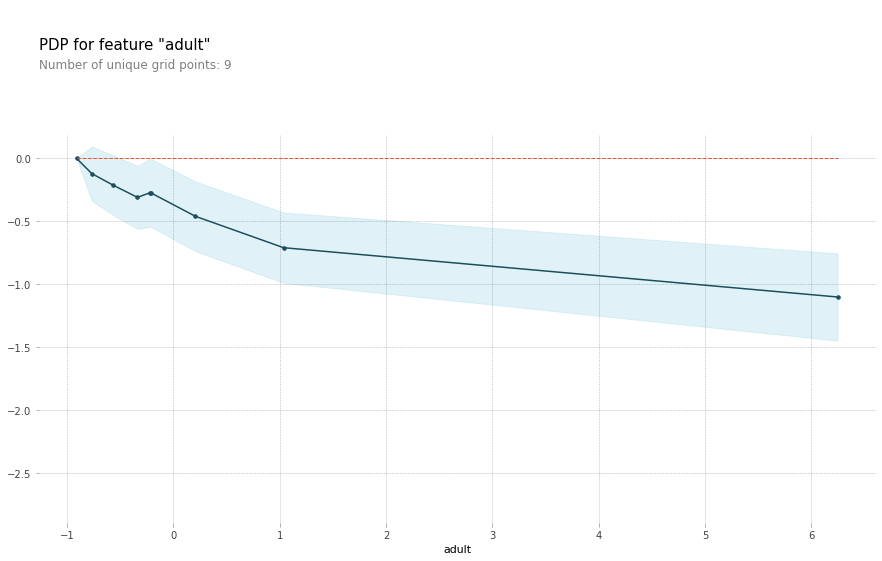

In [32]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
feature = 'adult'
isolate = pdp_isolate(model=model_gbrt,
                     dataset=pd.DataFrame(X_val,columns=X.columns),
                      model_features = X.columns,
                      feature = feature,
                      n_jobs=2
                     )
pdp_plot(isolate,feature_name=feature );


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='adult', ylabel='popularity'>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


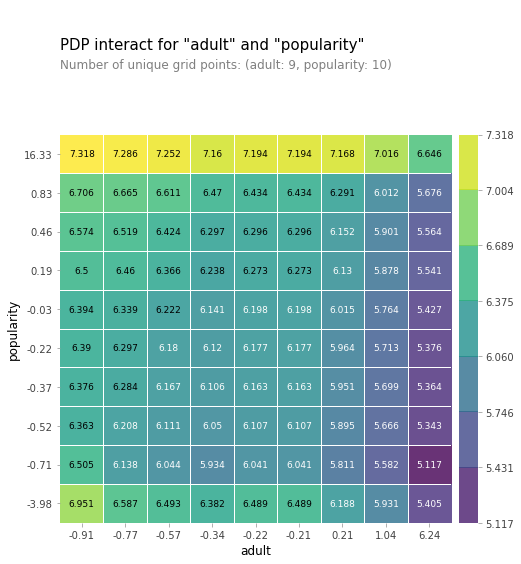

In [33]:
features = ['adult','popularity']

interact = pdp_interact(model=model_gbrt,
                     dataset=pd.DataFrame(X_val,columns=X.columns),
                      model_features = X.columns,
                      features = features,
                      n_jobs=2)

pdp_interact_plot(interact, plot_type='grid', feature_names=features )

In [34]:
!pipenv install shap

Installing shap...
Adding shap to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock (04a997) out of date, updating to (b2e132)...
Locking [dev-packages] dependencies...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Updated Pipfile.lock (b2e132)!
Installing dependencies from Pipfile.lock (b2e132)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00


In [35]:
from shap import TreeExplainer, initjs, force_plot

initjs()
explainer = TreeExplainer(model_gbrt)

row = X_val[-4]

force_plot(
    base_value=explainer.expected_value,
    shap_values=explainer.shap_values(row),
    features=row
)


In [36]:
x_val_dataset=pd.DataFrame(X_val,columns=X.columns, index=y_val.index)
display(x_val_dataset)
display(y_val)


,id,adult,budget,original_language,popularity,revenue,runtime,status,video,country,genre_list,Animation,Comedy,Family,Adventure,...,Drama,Action,Crime,Thriller,Horror,History,Mystery,War,Foreign,Music,Documentary,Western,Aniplex,GoHands,pro_co
3958,0.0,-0.565270,0.141561,-0.420484,-0.108757,-0.0121,-0.290024,-0.745441,2.860324,2.249717,3.007588,2.300012,1.099009,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,3959.0,1.0,1.0,4.0,919.0,2976.0
2662,0.0,-0.220131,-0.173381,-0.466976,-0.334473,-0.0121,-0.290024,-0.745441,-0.349611,-0.444500,-0.332492,-0.434780,1.099009,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,8.122228,-0.124339,-0.0121,-0.0121,2663.0,1.0,1.0,1.0,704.0,1866.0
928,0.0,-0.765571,0.056302,-0.072432,0.116959,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,-0.434780,-0.909910,1.802258,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,929.0,1.0,1.0,26.0,173.0,634.0
805,0.0,-0.865722,-0.092428,-0.466976,-0.785905,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,-0.434780,-0.909910,-0.554859,2.321655,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,806.0,1.0,1.0,1.0,114.0,574.0
3042,0.0,-0.822800,-0.429003,-0.344420,-0.447331,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,-0.434780,-0.909910,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,3043.0,1.0,1.0,1.0,4.0,2185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5097,0.0,-0.050210,-0.002194,-0.466976,-0.221615,-0.0121,-0.290024,-0.745441,-0.349611,-0.444500,-0.332492,-0.434780,1.099009,-0.554859,2.321655,...,-0.196518,3.352900,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,5098.0,1.0,1.0,2.0,910.0,3946.0
5913,0.0,-0.220131,0.161245,-0.466976,1.095062,-0.0121,-0.290024,-0.745441,-0.349611,2.249717,-0.332492,-0.434780,1.099009,1.802258,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,5914.0,6.0,1.0,36.0,170.0,4659.0
5078,0.0,-0.479427,-0.194625,-0.341079,-0.597809,-0.0121,-0.290024,-0.745441,-0.349611,-0.444500,-0.332492,-0.434780,1.099009,-0.554859,2.321655,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,5079.0,1.0,1.0,1.0,13.0,3931.0
1398,0.0,-0.220131,0.013394,-0.345504,-0.259234,-0.0121,-0.290024,1.341488,-0.349611,-0.444500,-0.332492,2.300012,1.099009,-0.554859,-0.430727,...,-0.196518,-0.298249,-0.176336,0.0,-0.17853,-0.123119,-0.124339,-0.0121,-0.0121,1399.0,1.0,1.0,1.0,9.0,938.0


3958    5.954088
2662    6.427281
928     6.735114
805     6.562521
3042    6.052300
          ...   
5097    5.286373
5913    6.647475
5078    5.320274
1398    6.171771
6619    7.890339
Name: score, Length: 1367, dtype: float64

In [37]:
cell_pred = model_gbrt.predict(X_val)

In [38]:
compare_results = list(zip(cell_pred, y_val))
print(compare_results)

[(6.256080157822479, 5.954087585778241), (6.701774295608938, 6.427280737080688), (6.418342301371414, 6.7351140890119465), (6.360949824431061, 6.562521203247023), (5.849115230449226, 6.0523002837182), (6.120458523840775, 5.93469870979489), (6.0872331166052005, 5.9672201883391605), (5.565407339620317, 5.779466930634958), (6.752300735758604, 7.316737519763633), (6.68716656511107, 6.471308941803253), (6.20552756102167, 6.063694261831367), (5.936004036189587, 5.9821597791825525), (6.335335914030602, 6.999215157338978), (6.533968312173246, 5.03050119833994), (6.608512102565517, 6.965455180378347), (5.647301734362428, 5.8270331029888345), (6.096619951220984, 6.2581703354888925), (6.300191377735166, 7.052411116052027), (5.767087166176966, 5.607143500674539), (6.294768944802876, 6.965871826066749), (6.185452205066577, 5.871635789832247), (6.637446057220728, 5.914329291263346), (6.1251830882712355, 6.567074524741135), (6.214694778009116, 6.064182222702608), (5.736874855955692, 5.5266290979147765

In [76]:
result_interest = compare_results[4]
print(result_interest)

(5.849115230449226, 6.0523002837182)


In [77]:
models={'model1': (model_lr,'linear_regressor.mod'), 'model2': (model_rfr, 'random_forest.mod'),
        'model3': (model_gbrt, 'gradient_boost.mod')}

In [78]:
###############
# SAVE MODELS #
###############
for model in models:
    filename = 'static/'+models[model][1]
    pickle.dump(models[model][0], open(filename, 'wb'))


In [80]:
def place_score(df1, value):
  for idx in range(len(df1)):
    if (df1.iloc[idx,0] > value) and (df1.iloc[idx+1,0] < value):
      return idx
    elif idx == (len(df1)-2): return None
  return None

place_score(catalogue_final[['score']],5.9)

In [81]:
catalogue_final.iloc[2730]

key_0                                        16740
id                                           50725
imdb_id                                  tt0810922
original_title                Take Me Home Tonight
poster_path       /glRBoVKClP7qYQO0gQi5keCQ6ko.jpg
score                                      6.03937
Name: 4372, dtype: object

In [91]:
!pipenv install yellowbrick
!pipenv --venv

Installing yellowbrick...
Adding yellowbrick to Pipfile's [packages]...
✔ Installation Succeeded 
Installing dependencies from Pipfile.lock (43c5fe)...
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 0/0 — 00:00:00
/home/afroroboticist/.virtualenvs/movieRec-GPy9DBCD


In [93]:
from yellowbrick.regressor import ResidualsPlot

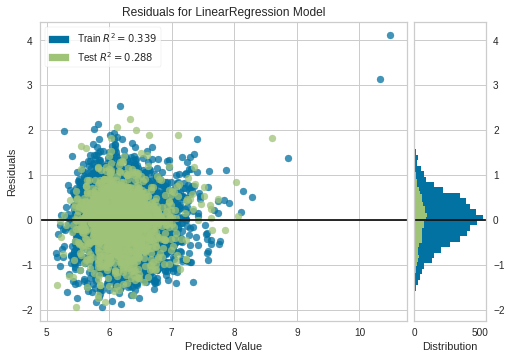

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [96]:


# Instantiate the linear model and visualizer
visualizer_lr = ResidualsPlot(model_lr)

visualizer_lr.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_lr.score(X_val, y_val)  # Evaluate the model on the test data
visualizer_lr.show()                 # Finalize and render the figure

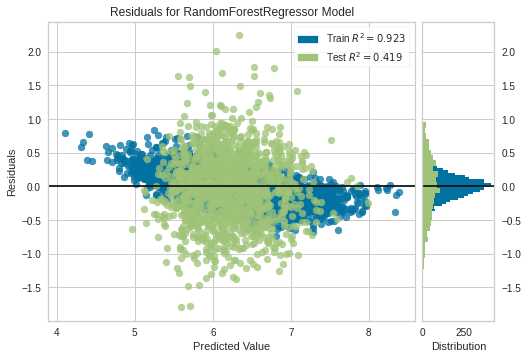

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [97]:
visualizer_rfr = ResidualsPlot(model_rfr)

visualizer_rfr.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_rfr.score(X_val, y_val)  # Evaluate the model on the test data
visualizer_rfr.show()  

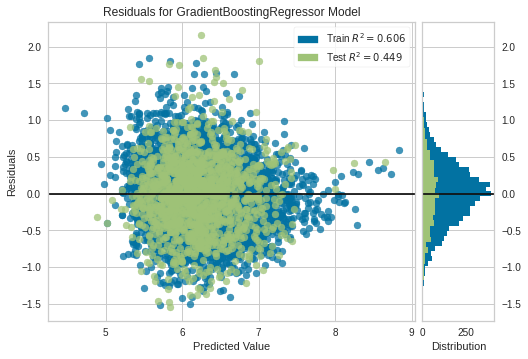

<AxesSubplot:title={'center':'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [98]:
visualizer_gbrt = ResidualsPlot(model_gbrt)

visualizer_gbrt.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer_gbrt.score(X_val, y_val)  # Evaluate the model on the test data
visualizer_gbrt.show()